In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [3]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')

--2025-05-28 22:32:21--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 172.67.70.149, 104.26.3.33, 104.26.2.33
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|172.67.70.149|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv’

insurance.csv       100%[===================>]  49.09K  --.-KB/s    in 0.005s  

2025-05-28 22:32:22 (9.77 MB/s) - ‘insurance.csv’ saved [50264/50264]



In [4]:
print(dataset.tail())

      age     sex   bmi  children smoker     region  expenses
1333   50    male  31.0         3     no  northwest  10600.55
1334   18  female  31.9         0     no  northeast   2205.98
1335   18  female  36.9         0     no  southeast   1629.83
1336   21  female  25.8         0     no  southwest   2007.95
1337   61  female  29.1         0    yes  northwest  29141.36


In [5]:
dataset = pd.get_dummies(dataset, columns=['sex'], prefix='', prefix_sep='')

In [6]:
print(dataset.tail())

      age   bmi  children smoker     region  expenses  female   male
1333   50  31.0         3     no  northwest  10600.55   False   True
1334   18  31.9         0     no  northeast   2205.98    True  False
1335   18  36.9         0     no  southeast   1629.83    True  False
1336   21  25.8         0     no  southwest   2007.95    True  False
1337   61  29.1         0    yes  northwest  29141.36    True  False


In [7]:
dataset = pd.get_dummies(dataset, columns=['smoker'], prefix='', prefix_sep='')

In [8]:
dataset = dataset.rename(columns={'no': 'not_smoker'})
dataset = dataset.rename(columns={'yes': 'smoker'})

In [9]:
print(dataset.tail())

      age   bmi  children     region  expenses  female   male  not_smoker  \
1333   50  31.0         3  northwest  10600.55   False   True        True   
1334   18  31.9         0  northeast   2205.98    True  False        True   
1335   18  36.9         0  southeast   1629.83    True  False        True   
1336   21  25.8         0  southwest   2007.95    True  False        True   
1337   61  29.1         0  northwest  29141.36    True  False       False   

      smoker  
1333   False  
1334   False  
1335   False  
1336   False  
1337    True  


In [10]:
dataset = pd.get_dummies(dataset, columns=['region'], prefix='', prefix_sep='')

In [11]:
print(dataset.tail())

      age   bmi  children  expenses  female   male  not_smoker  smoker  \
1333   50  31.0         3  10600.55   False   True        True   False   
1334   18  31.9         0   2205.98    True  False        True   False   
1335   18  36.9         0   1629.83    True  False        True   False   
1336   21  25.8         0   2007.95    True  False        True   False   
1337   61  29.1         0  29141.36    True  False       False    True   

      northeast  northwest  southeast  southwest  
1333      False       True      False      False  
1334       True      False      False      False  
1335      False      False       True      False  
1336      False      False      False       True  
1337      False       True      False      False  


In [12]:
dataset = dataset.replace({True: 1, False: 0})

In [13]:
print(dataset.tail())

      age   bmi  children  expenses  female  male  not_smoker  smoker  \
1333   50  31.0         3  10600.55       0     1           1       0   
1334   18  31.9         0   2205.98       1     0           1       0   
1335   18  36.9         0   1629.83       1     0           1       0   
1336   21  25.8         0   2007.95       1     0           1       0   
1337   61  29.1         0  29141.36       1     0           0       1   

      northeast  northwest  southeast  southwest  
1333          0          1          0          0  
1334          1          0          0          0  
1335          0          0          1          0  
1336          0          0          0          1  
1337          0          1          0          0  


In [14]:
# Split data into a training and test set

train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [15]:
print(train_dataset)

      age   bmi  children  expenses  female  male  not_smoker  smoker  \
578    52  30.2         1   9724.53       0     1           1       0   
610    47  29.4         1   8547.69       1     0           1       0   
569    48  40.6         2  45702.02       0     1           0       1   
1034   61  38.4         0  12950.07       0     1           1       0   
198    51  18.1         0   9644.25       1     0           1       0   
...   ...   ...       ...       ...     ...   ...         ...     ...   
584    19  20.7         0   1242.82       0     1           1       0   
147    51  37.7         1   9877.61       1     0           1       0   
160    42  26.6         0  21348.71       1     0           0       1   
750    37  26.4         0  19539.24       1     0           0       1   
859    57  28.1         0  10965.45       0     1           1       0   

      northeast  northwest  southeast  southwest  
578           0          0          0          1  
610           0      

In [16]:
print(test_dataset)

      age   bmi  children  expenses  female  male  not_smoker  smoker  \
11     62  26.3         0  27808.73       1     0           0       1   
23     34  31.9         1  37701.88       1     0           0       1   
24     37  28.0         2   6203.90       0     1           1       0   
25     59  27.7         3  14001.13       1     0           1       0   
28     23  17.4         1   2775.19       0     1           1       0   
...   ...   ...       ...       ...     ...   ...         ...     ...   
1305   24  27.7         0   2464.62       1     0           1       0   
1315   18  28.3         1  11272.33       0     1           1       0   
1318   35  39.7         4  19496.72       0     1           1       0   
1326   42  32.9         0   7050.02       1     0           1       0   
1333   50  31.0         3  10600.55       0     1           1       0   

      northeast  northwest  southeast  southwest  
11            0          0          1          0  
23            1      

/Users/adisontan/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


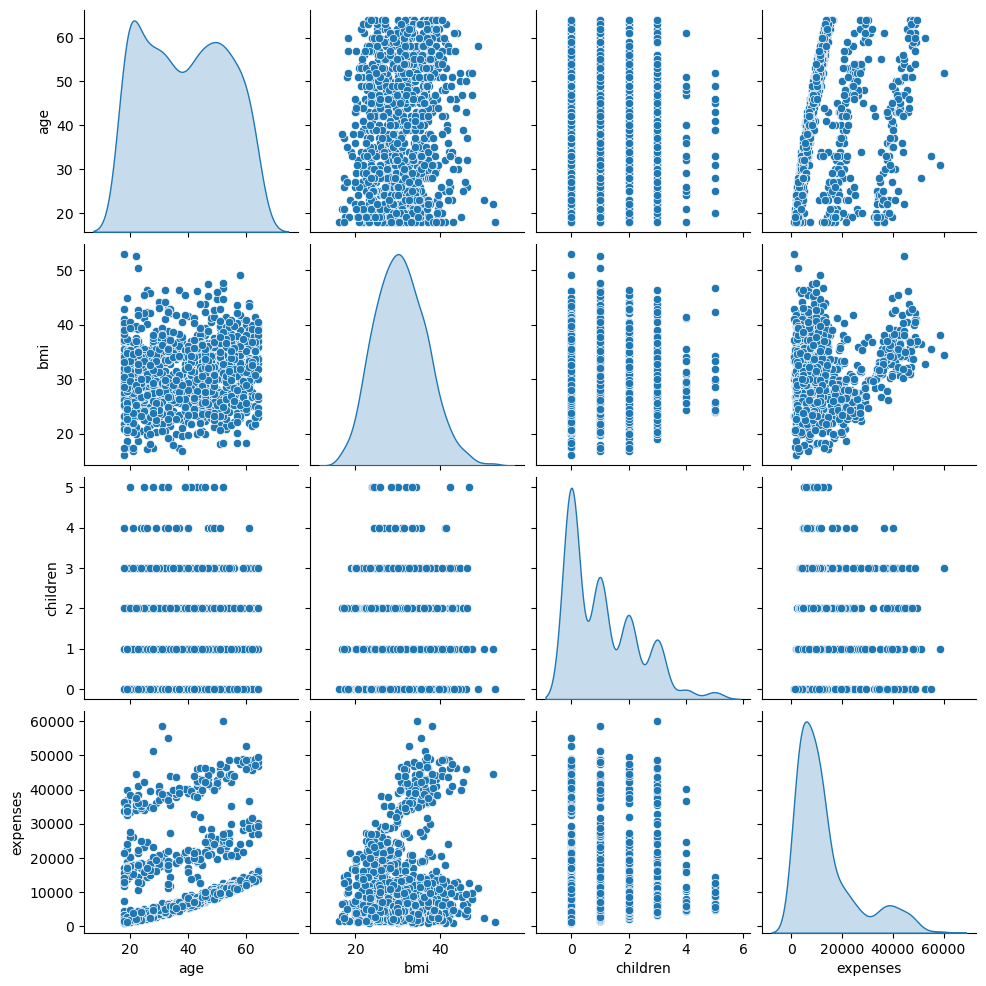

In [17]:
# Data visualisation

sns.pairplot(train_dataset[['age', 'bmi', 'children', 'expenses']], diag_kind='kde')

In [18]:
# Data statistics

print(train_dataset.describe().transpose())

             count          mean           std      min       25%       50%  \
age         1070.0     39.036449     14.142122    18.00    26.000    39.000   
bmi         1070.0     30.737290      6.065193    16.00    26.300    30.500   
children    1070.0      1.093458      1.211364     0.00     0.000     1.000   
expenses    1070.0  13056.551654  11994.260172  1121.87  4565.995  9289.085   
female      1070.0      0.501869      0.500230     0.00     0.000     1.000   
male        1070.0      0.498131      0.500230     0.00     0.000     0.000   
not_smoker  1070.0      0.800935      0.399484     0.00     1.000     1.000   
smoker      1070.0      0.199065      0.399484     0.00     0.000     0.000   
northeast   1070.0      0.248598      0.432402     0.00     0.000     0.000   
northwest   1070.0      0.235514      0.424518     0.00     0.000     0.000   
southeast   1070.0      0.281308      0.449848     0.00     0.000     0.000   
southwest   1070.0      0.234579      0.423934     0

In [19]:
# Get label dataset

train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('expenses')
test_labels = test_features.pop('expenses')

In [20]:
# Build the linear regression model
model = Sequential()
model.add(Dense(1, input_dim=train_dataset.shape[1], activation='linear'))

# Compile the model
model.compile(optimizer='adam',
              loss='mean_absolute_error',
              metrics=["mean_absolute_error", "mean_squared_error"])

# Stop training when a model stops improving
monitor = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    train_dataset, train_labels,
    validation_data=(test_dataset, test_labels),
    epochs=100,
    batch_size=32,
    callbacks=[monitor],
    verbose=1
)

# Evaluate the model on the test set
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=0)
print(f'Test Mean Absolute Error: {mae:.2f}')
print(f'Test Mean Square Error: {mse:.2f}')

Epoch 1/100
34/34 [==============================] - 0s 4ms/step - loss: 10672.3076 - mean_absolute_error: 10672.3076 - mean_squared_error: 209939440.0000 - val_loss: 11296.4756 - val_mean_absolute_error: 11296.4756 - val_mean_squared_error: 228007472.0000
Epoch 2/100
34/34 [==============================] - 0s 1ms/step - loss: 10231.0938 - mean_absolute_error: 10231.0938 - mean_squared_error: 192933488.0000 - val_loss: 10821.4951 - val_mean_absolute_error: 10821.4951 - val_mean_squared_error: 209278528.0000
Epoch 3/100
34/34 [==============================] - 0s 1ms/step - loss: 9791.7334 - mean_absolute_error: 9791.7334 - mean_squared_error: 177049616.0000 - val_loss: 10342.8135 - val_mean_absolute_error: 10342.8135 - val_mean_squared_error: 191215360.0000
Epoch 4/100
34/34 [==============================] - 0s 1ms/step - loss: 9349.4355 - mean_absolute_error: 9349.4355 - mean_squared_error: 161131984.0000 - val_loss: 9869.6807 - val_mean_absolute_error: 9869.6807 - val_mean_squared_

9/9 - 0s - loss: 1.1759 - mean_absolute_error: 1.1759 - mean_squared_error: 1.9950 - 82ms/epoch - 9ms/step
Testing set Mean Abs Error:  1.18 expenses
You passed the challenge. Great job!
9/9 [==============================] - 0s 469us/step


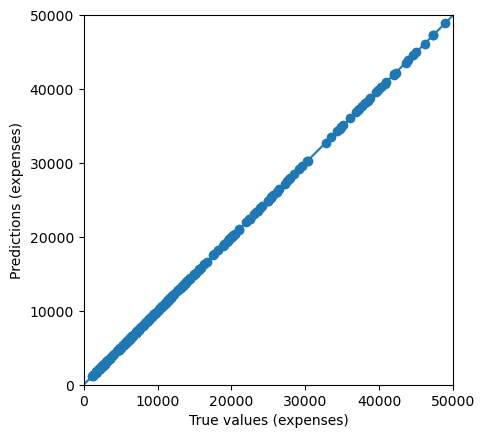

In [24]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_dataset, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_dataset).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
